# iQuHACK 2023

* Team name: HaQ

We chose to tackle the IonQ remote challenge.

This challenge had two major components: data encoding and decoding, and classification.

In [124]:
# Preamble: install everything we need
!pip install qiskit numpy matplotlib scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
# Preamble: import everything we need
import numpy as np
import qiskit
import matplotlib.pyplot as plt
import scipy.fftpack

In [126]:
# Provided by IonQ
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = qiskit.BasicAer.get_backend('statevector_simulator')
    job = qiskit.execute_function.execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

In [144]:
# Helper function
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

## Encoding

Our input data are images of clothes, as part of the MNIST fashion dataset. So, for an image of $N \times N$ pixels, we consider some $N\times N$ matrix $D$, such that $D_{ij}$ is the brightness of the pixel in position $(i, j)$, normalized to be in the $[0,1]$ range.

It's easy to perform a straight-forward block-encoding of the matrix $D$, which
we started by doing: we note that we want a transformation that acts as

$$ \def\ket#1{\vert{#1}\rangle} \ket{i} \ket{j} \ket{0} \mapsto
      \ket{i} \ket{j} (\sqrt{D_{ij}} \ket{0} + \ldots \ket{1}) $$

which we can achieve with a controlled $R_y$ rotation on an auxilliary (the block-encoding) qubit, i.e.,

$$ D = \Pi_{i=1}^N \Pi_{j=1}^N \vert i \rangle\langle i \vert \otimes
  \vert j \rangle \langle j \vert \otimes R_y(2 \arccos \sqrt{D_{ij}})$$

Let this block-encoding of $D$ be $U_D$.

From this encoding, producing an FRQI encoding simply corresponds to applying
$U_D$ to a uniform superposition on the possible input indices.

$$ \vert \mbox{FRQI} \rangle = U_D (H^{\otimes n} \vert 0^n \rangle \otimes
  H^{\otimes n} \vert 0^n \rangle) $$

Then, decoding the image is just a matter of estimating the odds of measuring
$0$ in the last register, given that we measured a particular index position in
the first two registers:

$$ \tilde{D_{ij}} = \mbox{Prob}[i \oplus j \oplus 0 | i \oplus j] $$

Since we provided as input a uniform superposition of indices, we measure a given index with uniform probability.

We can see that this scheme works well:

In [146]:
def block_encoding(data):
    """Performs a block-encoding of the input data.
    
    Arguments:
        data      A numpy array that describes an NxN image in black & white,
                  with 0 corresponding to darkest, and 1 to brightest.
    
    Returns:
        A qiskit quantum circuit block-encoding the data in an auxiliary qubit.
    """
    # Check the dimensions of the input data
    r, c = np.shape(data)
    if r != c:
        raise ValueError("Error: Please provide a square image.")
    
    # Calculate how many qubits we'll need to represent indices into this data.
    n_qubits = int(np.ceil(np.log2(r)))
    print(f"Log: considering {n_qubits} qubits to index image side {r}")
    
    # Normalize the data to have infinity norm 1 (otherwise we can't BE it).
    # Also, just in case, to be positive semidefinite.
    data = (data + np.min(data)) / (np.max(data) - np.min(data))
    
    # What will hold our final BEing circuit.
    qubits = qiskit.QuantumRegister(2*n_qubits+1)
    circuit = qiskit.QuantumCircuit(qubits)

    for index_i in range(r):
        # Write i in binary.
        i_bin_str = '{ind:0{q}b}'.format(q=n_qubits, ind=index_i)
        i_binary = tuple(int(b) for b in i_bin_str)
        
        for index_j in range(c):
            # Write j in binary.
            j_bin_str = '{ind:0{q}b}'.format(q=n_qubits, ind=index_j)
            j_binary = tuple(int(b) for b in j_bin_str)
            
            # We are going to implement the action of D as a rotation, so we need
            # to know the ocrresponding angle.
            # Note that cirq's definition of rx considers the angle to be
            #  (arg)/2.
            angle = 2. * np.arccos(np.sqrt(data[index_i, index_j]))
            
            # The rotation is controlled by the relevant index register qubits.
            rotation = qiskit.circuit.library.RYGate(angle)
            rotation = rotation.control(num_ctrl_qubits=2*n_qubits,
                                        ctrl_state=(i_bin_str + j_bin_str)[::-1])
            circuit.append(rotation, qubits)
    
    return circuit

In [147]:
def frqi_encode(data):
    """Performs an FRQI encoding of the input data.
    
    Arguments:
        data      A numpy array that describes an NxN image in black & white,
                  with 0 corresponding to darkest, and 1 to brightest.
    
    Returns:
        A qiskit quantum circuit with an FRQI encoding of the data.
    """
    be_circuit = block_encoding(data)
    n_qubits = len(be_circuit.qubits)
    diffusion_circuit = qiskit.QuantumCircuit(n_qubits)
    for q_i in range(n_qubits-1):
        diffusion_circuit.h(q_i)
    diffusion_circuit.compose(be_circuit, inplace=True)
    return diffusion_circuit

Log: considering 2 qubits to index image side 4
     ┌───┐                                                                 »
q_0: ┤ H ├────o──────────o─────────────o─────────────o─────────────o───────»
     ├───┤    │          │             │             │             │       »
q_1: ┤ H ├────o──────────o─────────────o─────────────o─────────────■───────»
     ├───┤    │          │             │             │             │       »
q_2: ┤ H ├────o──────────o─────────────■─────────────■─────────────o───────»
     ├───┤    │          │             │             │             │       »
q_3: ┤ H ├────o──────────■─────────────o─────────────■─────────────o───────»
     └───┘┌───┴───┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐»
q_4: ─────┤ Ry(0) ├┤ Ry(0.6435) ├┤ Ry(1.3694) ├┤ Ry(2.2143) ├┤ Ry(0.9273) ├»
          └───────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«                                                                        »
«q_0: ──────o─────────────o───

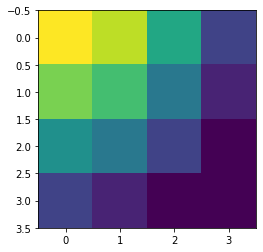

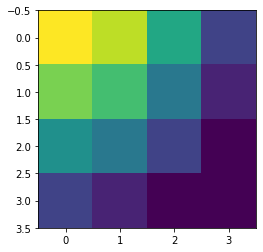

In [148]:
def test():
    data = np.array([[1.0, 0.9, 0.6, 0.2],
                     [0.8, 0.7, 0.4, 0.1],
                     [0.5, 0.4, 0.2, 0.0],
                     [0.2, 0.1, 0.0, 0.0]])
    circuit = frqi_encode(data)
    print(circuit)
    histogram = simulate(circuit)

    image_re = np.zeros(data.shape)
    for i in range(4):
        for j in range(4):
            key = (i << 2) + j
            key = '{:04b}'.format(key)
            key = int(key[::-1], 2)
            image_re[i, j] = histogram.get(key, 0.)

    plt.imshow(data)
    plt.show()
    plt.imshow(image_re)
    plt.show()

test()
del test

### Doing better

However, such a scheme requires one multi-controlled gate for each pixel of the 
image, i.e., if the image is $N \times N$, it requires $N^2$ multi-controlled gates. Furthermore, each of these multi-controlled gates is controlled by every
qubit in the indices register, meaning each gate has $2n$ controls. 

This was too demanding for our present case, so we took a different approach: instead of block-encoding (and the FRQI-encoding) the image itself, and inspired by, for example, the JPEG image format, we start by performing a Discrete Cosine Transformation on our input data.

This results in many zeroed entries, or very small entries, in the data, that we can consider in a single global phase shift. For the remaining non-small entries, which are, in principle, much fewer than $N^2$, we can have a controlled rotation as before for the necessary offset.

We further compress the input data by truncating high frequencies before we encode it into the quantum circuit.

In [130]:
def compress(image, size, eps=0):
    """Converts an image into its 2D-DCT, with some normalization."""
    a = scipy.fftpack.dctn(image)
    comp_freqs = a[:size,:size]
    max_freq = np.max(np.abs(comp_freqs))
    return comp_freqs/max_freq, max_freq

def decompress(freqs, scale, size):
    """Converts an image in 2D-DCT space back to real space."""
    new_freqs = np.zeros((size, size))
    s = freqs.shape[0]
    new_freqs[:s,:s] = freqs/scale
    reconstructed_image = scipy.fftpack.idctn(new_freqs)
    return reconstructed_image

In [131]:
def encode(image, eps=1e-6):
    if image.shape[0] != image.shape[1]:
        raise ValueError('Image must be square.')
    if np.min(image) < 0:
        raise ValueError('Image cannot have negative entries.')
    
    image_side = image.shape[0]
    n = image_side.bit_length() - 1
    
    q = qiskit.QuantumRegister(2*n+1)
    ct= qiskit.QuantumCircuit(q)
        
    # The DCT maps onto [-1, 1]; since we'll be estimating probabilities,
    # we need the domain to be [0, 1].
    image /= np.max(np.abs(image))
    image += 1
    image /= 2
    
    ct.h([qi for qi in q][:-1])
    
    for i in range(len(image)):
        for j in range(len(image[0])):
            
            aux_i = bin(i)[2:].zfill(n)
            aux_j = bin(j)[2:].zfill(n)
            
            theta = (image[i,j] - 0.5)*np.pi/2
            
            if abs(theta)>eps:
                rotation = qiskit.circuit.library.RYGate(2.*theta)
                rotation = rotation.control(num_ctrl_qubits=2*n,
                                            ctrl_state=(aux_i + aux_j))
                ct.append(rotation, q)
    ct.ry(2 * np.pi/4, q[-1])
            
    return ct

In [132]:
def decode(histogram, image_side):
    # This function considers that the histogram is actually the probabilities
    # computed via the wavefunction.
    index_reg_qubits = int(np.ceil(np.log2(image_side)))
    total_qubits = 2*index_reg_qubits + 1
    n_pixels = image_side**2

    # The matix to which we'll place our reconstructed image...
    data = np.zeros((image_side, image_side))
    
    for key in range(2**total_qubits):
        arr = bin_array(key, total_qubits)
        if arr[0]==0:
            arr_1, arr_2 = np.split(arr[1:], 2)
            c_1 = arr_1[::-1].dot(2**np.arange(arr_1.size)[::-1])
            c_2 = arr_2[::-1].dot(2**np.arange(arr_2.size)[::-1])
            data[c_2,c_1] = (4/np.pi) * np.arccos(np.sqrt(histogram.get(key,0.) * n_pixels)) - 1
            #print(key, arr_1, arr_2, c_1, c_2)

    return data

        ┌───┐                                                        »
q171_0: ┤ H ├─────o────────────■──────────────o──────────────■───────»
        ├───┤     │            │              │              │       »
q171_1: ┤ H ├─────o────────────o──────────────■──────────────■───────»
        └───┘┌────┴────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
q171_2: ─────┤ Ry(π/2) ├┤ Ry(0.61208) ├┤ Ry(0.65966) ├┤ Ry(0.17207) ├»
             └─────────┘└─────────────┘└─────────────┘└─────────────┘»
«                   
«q171_0: ───────────
«                   
«q171_1: ───────────
«        ┌─────────┐
«q171_2: ┤ Ry(π/2) ├
«        └─────────┘


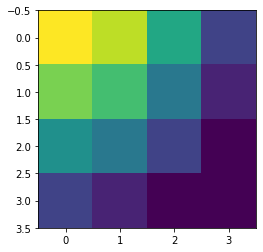

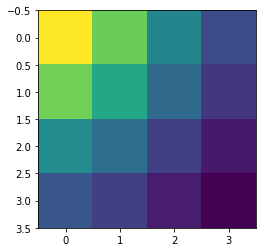

In [133]:
def test():
    data = np.array([[1.0, 0.9, 0.6, 0.2],
                        [0.8, 0.7, 0.4, 0.1],
                        [0.5, 0.4, 0.2, 0.0],
                        [0.2, 0.1, 0.0, 0.0]])

    freqs, scale = compress(data, 2)
    circuit=encode(freqs.copy(), eps=5e-2)
    print(circuit)
    histogram=simulate(circuit)
    freqs_re=decode(histogram, freqs.shape[0])
    image_re = decompress(freqs_re, scale, data.shape[0])

    plt.imshow(data)
    plt.show()
    plt.imshow(image_re)
    plt.show()

test()
del test

As shown above, this encoding scheme saves us gate depth and width, and works well.

We collected the relevant functions above into `submission_part1.py`.

## Classification

Now that we have an encoding and decoding scheme, we moved onto classification.

We chose to use a Quantum Convolutional Neural Network, for which Qiskit has already some facilities.

As described by the [Qiskit documentation][qcnn], the convolutional layers and the pooling layers are of the following stucture:

[qcnn]: https://qiskit.org/documentation/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

In [157]:
def show_conv():
    def conv_circuit(params):
        target = qiskit.circuit.QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)
        target.cx(1, 0)
        target.rz(np.pi / 2, 0)
        return target

    def conv_layer(num_qubits, param_prefix):
        qc = qiskit.circuit.QuantumCircuit(num_qubits,
                                           name="Convolutional Layer")
        qubits = list(range(num_qubits))
        param_index = 0
        params = qiskit.circuit.ParameterVector(param_prefix,
                                                length=num_qubits * 3)
        for q1, q2 in zip(qubits[0::2], qubits[1::2]):
            qc = qc.compose(
                conv_circuit(params[param_index : (param_index + 3)]),
                [q1, q2])
            qc.barrier()
            param_index += 3
        for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
            qc = qc.compose(
                conv_circuit(params[param_index : (param_index + 3)]),
                [q1, q2])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = qiskit.circuit.QuantumCircuit(num_qubits)
        qc.append(qc_inst, qubits)
        return qc

    params = qiskit.circuit.ParameterVector("θ", length=3)
    circuit = conv_circuit(params)
    print("Convolution gadget:")
    print(circuit)
    print('')
    print("Convolution layer:")
    circuit = conv_layer(4, "θ")
    print(circuit.decompose())

show_conv()
del show_conv

Convolution gadget:
                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘                

Convolution layer:
                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■──────────────░─»
     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
q_3: ───────────────────────────────────────────────────────────────░─»
                                            

In [158]:
def show_pool():
    def pool_circuit(params):
        target = qiskit.circuit.QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)

        return target

    def pool_layer(sources, sinks, param_prefix):
        num_qubits = len(sources) + len(sinks)
        qc = qiskit.circuit.QuantumCircuit(num_qubits, name="Pooling Layer")
        param_index = 0
        params = qiskit.circuit.ParameterVector(
            param_prefix, length=num_qubits // 2 * 3)
        for source, sink in zip(sources, sinks):
            qc = qc.compose(
                pool_circuit(params[param_index : (param_index + 3)]),
                [source, sink])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = qiskit.circuit.QuantumCircuit(num_qubits)
        qc.append(qc_inst, range(num_qubits))
        return qc

    params = qiskit.circuit.ParameterVector("θ", length=3)
    circuit = pool_circuit(params)
    print('Pooling gadget:')
    print(circuit)
    print('')

    sources = [0, 1]
    sinks = [2, 3]
    circuit = pool_layer(sources, sinks, "θ")
    print('Pooling layer:')
    print(circuit.decompose())

show_pool()
del show_pool


Pooling gadget:
                 ┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘

Pooling layer:
                 ┌───┐┌──────────┐                  ░                  »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■───────────────░──────────────────»
                 └─┬─┘└──────────┘  │               ░             ┌───┐»
q_1: ──────────────┼────────────────┼───────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────┐┌─┴─┐┌──────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├─░───────────────┼──»
     └──────────┘     └──────────┘└───┘└──────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                    ░ └──────────┘     »
«                                   ░ 
«q_0: ──────